grid[0].g.shape: (5, 58)
grid[1].g.shape: (5, 58)
grid[2].g.shape: (5, 58)
grid[3].g.shape: (5, 58)
grid[4].g.shape: (5, 58)
grid[5].g.shape: (5, 58)
grid[6].g.shape: (5, 58)
grid[7].g.shape: (5, 58)
grid[8].g.shape: (5, 58)
grid[9].g.shape: (5, 58)
grid[10].g.shape: (5, 58)
grid[11].g.shape: (5, 58)
grid[12].g.shape: (5, 58)
grid[13].g.shape: (5, 58)
grid[14].g.shape: (5, 58)
grid[15].g.shape: (5, 58)
grid[16].g.shape: (5, 58)
grid[17].g.shape: (5, 58)
grid[18].g.shape: (5, 58)
grid[19].g.shape: (5, 58)
grid[20].g.shape: (5, 58)
grid[21].g.shape: (5, 58)
grid[22].g.shape: (5, 58)
grid[23].g.shape: (5, 58)
grid[24].g.shape: (5, 58)
grid[25].g.shape: (5, 58)
grid[26].g.shape: (5, 58)
grid[27].g.shape: (5, 58)
grid[28].g.shape: (5, 58)
grid[29].g.shape: (5, 58)
grid[30].g.shape: (5, 58)
grid[31].g.shape: (5, 58)
grid[32].g.shape: (5, 58)
grid[33].g.shape: (5, 58)
grid[34].g.shape: (5, 58)
grid[35].g.shape: (5, 58)
grid[36].g.shape: (5, 58)
grid[37].g.shape: (5, 58)
grid[38].g.shape: (5, 

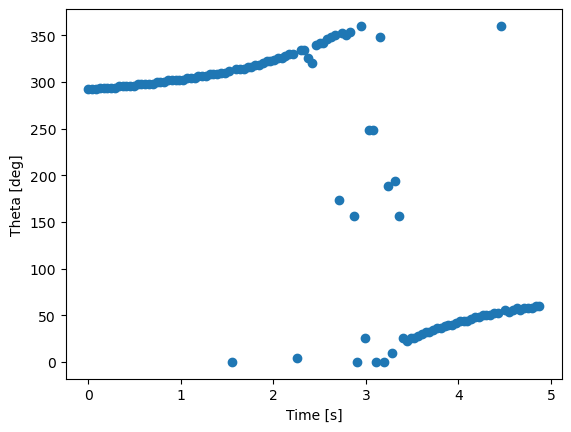

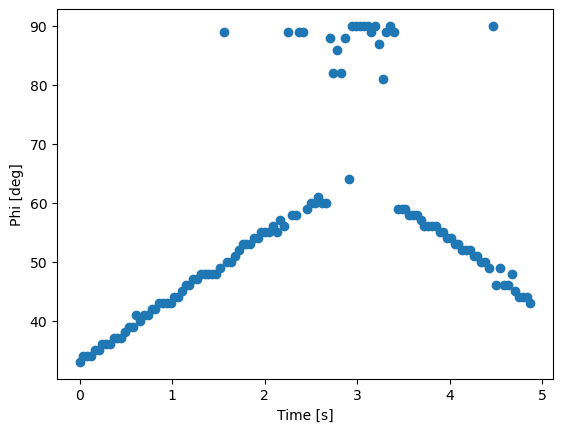

In [9]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd

drone="Autel_Evo"

# Grid point characteristics
class Grid_point:
    def __init__(self, r, theta, phi, beam, g):
        self.r = r
        self.theta = theta
        self.phi = phi
        self.beam = beam
        self.g = g

class Microphone:
    def __init__(self, r, theta, phi):
        self.r = r
        self.theta = theta
        self.phi = phi

# Calculate the steering vectors 
def get_steering_vector(scan_r, scan_theta, scan_phi, F, C, m_r, m_theta):
    scan_r = scan_r[:, np.newaxis]  # Shape: (703, 1)
    scan_theta = scan_theta[:, np.newaxis]  # Shape: (703, 1)
    scan_phi = scan_phi[:, np.newaxis]  # Shape: (703, 1)
    
    m_r = m[:, 0]  # Shape: (58,)
    m_theta = m[:, 1]  # Shape: (58,)

    dist = np.sqrt((scan_r * np.sin(scan_phi))**2 +
                   (scan_r * np.cos(scan_phi) * np.cos(scan_theta) - m_r * np.cos(m_theta))**2 +
                   (scan_r * np.cos(scan_phi) * np.sin(scan_theta) - m_r * np.sin(m_theta))**2)
    z = np.exp(-(2 * np.pi * F * dist * complex(0 + 1j) / C)) / dist  # Shape: (703, 58)
    return z

# Main program

# Read pressure measurements
with open(f"C:\\Users\\Jakub\\OneDrive - Delft University of Technology\\Desktop\\School\\test analysis project\\Microphone data\\{drone}.csv", newline='') as drone_file:
    reader = csv.reader(drone_file)
    p = [
        [float(row[i]) for i in range(len(row)) if i not in (0, 16, 20, 40) and i < 62]
        for row in reader if row[0]
    ]

p = np.array(p)  # Columns are pressure measurements for the same microphone at different time instances
                 # Rows are for the same time instance across different microphones

# Read microphone coordinates
with open("config.txt") as m_file:
    m = [
        Microphone(
            np.sqrt(float(words[1])**2 + float(words[2])**2), 
            np.arctan2(float(words[2]), float(words[1])) % (2*np.pi), 
            0
        )
        for words in map(str.split, m_file) if words[0] not in ["1", "17", "21", "41", "63", "64"]
    ]
m = np.array([[mic.r, mic.theta] for mic in m])  # Convert to array for vectorized calculations

# Construct the grid
dtheta = 2
dphi = 1
phi = np.arange(0, 91, dphi)
theta = np.arange(0, 361, dtheta)

# Construct the grid using broadcasting
phi_grid, theta_grid = np.meshgrid(np.radians(phi), np.radians(theta), indexing='ij')
r = 100  # Assuming r is constant

# Flatten the grids and create Grid_point objects
grid = [Grid_point(r, theta_val, phi_val, 0, []) for phi_val, theta_val in zip(phi_grid.flatten(), theta_grid.flatten())]

# Prepare the plot axes
x_axis = np.radians(np.arange(0, 361, dtheta))
y_axis = np.radians(np.arange(0, 91, dphi))
X, Y = np.meshgrid(x_axis, y_axis)

# Constants
C = 343  # Speed of sound in m/s
F = 1440  # Frequency needed for the steering vectors and fft
N = 4   # Frequency bands

fs = 50000  # Sampling frequency
wind = 4096  # Window size
df = (fs/2)/(wind/2)
n = round(F/df)

# Calculate the steering vectors for each grid point
scan_r = np.array([point.r for point in grid])
scan_theta = np.array([point.theta for point in grid])
scan_phi = np.array([point.phi for point in grid])

# Precompute steering vectors
ster_vectors = np.empty((len(grid), N, len(m)), dtype=np.complex128)
m_r = m[:, 0]  # Shape: (58,)
m_theta = m[:, 1]  # Shape: (58,)
for j in range(N):
    freq = (n + N // 2 - j) * df
    ster_vectors[:, j, :] = get_steering_vector(scan_r, scan_theta, scan_phi, freq, C, m_r, m_theta)

# Ensure that each grid point has the correct steering vectors
for j in range(len(grid)):
    grid[j].g = ster_vectors[j]
    print(f"grid[{j}].g.shape: {grid[j].g.shape}")  # Debugging

# Precompute FFTs for all windows
num_windows = (len(p) - wind) // (wind // 2)
p_fft_all = np.array([np.fft.fft(p[i:i + wind], axis=0) for i in range(0, len(p) - wind, wind // 2)])  # Shape: (num_windows, wind, num_mics)
p_fft_selected = p_fft_all[:, [n + 1 + N // 2 - k for k in range(N)], :]

# Initialize storage for results
beams_all = np.zeros((num_windows, len(grid)), dtype=np.complex128)

# Precompute auxiliary terms
g_all = np.array([[grid[j].g[k] for j in range(len(grid))] for k in range(N)])  # Shape: (N, len(grid), len(m))
g_star_all = np.conj(g_all)  # Shape: (N, len(grid), len(m))
g_norm_squared_all = np.linalg.norm(g_all, axis=2) ** 2  # Shape: (N, len(grid))

# Initialize lists to store results
theta_max = []
phi_max = []
time = []

# Iterate through each window's precomputed FFT
for i in range(num_windows):
    # Reset beam values for each grid point
    beams = np.zeros(len(grid), dtype=np.complex128)

    for k in range(N):
        p_fft = p_fft_selected[i, k, :]
        p_star = np.conj(p_fft)

        aux = np.outer(p_fft, p_star)  # Shape: (len(m), len(m))

        # Vectorize the inner loop
        g = g_all[k]  # Shape: (len(grid), len(m))
        g_star = g_star_all[k]  # Shape: (len(grid), len(m))
        g_norm_squared = g_norm_squared_all[k]  # Shape: (len(grid),)

        aux2 = aux.T @ g_star.T  # Shape: (len(grid), len(m))
        aux3 = np.sum(aux2 * g.T, axis=0)  # Shape: (len(grid),)
        beams += aux3 / g_norm_squared / N

    beams_all[i] = beams

    # Find max beam value
    max_index = np.argmax(beams)
    x_max = grid[max_index].theta
    y_max = grid[max_index].phi

    theta_max.append(x_max * 180 / np.pi)
    phi_max.append(y_max * 180 / np.pi)
    time.append(i * (wind // 2) / fs)

# Plot the trajectory of the sound source
plt.scatter(time, theta_max)
plt.xlabel("Time [s]")
plt.ylabel("Theta [deg]")
plt.show()

plt.scatter(time, phi_max)
plt.xlabel("Time [s]")
plt.ylabel("Phi [deg]")
plt.show()


In [ ]:
df = pd.DataFrame({
    'Time': time,
    'Theta': theta_max,
    'Phi': phi_max
})

df.to_csv(f'beamforming_values/{drone}.csv', index=False)